In [1]:
%load_ext autoreload
%autoreload 2

import pygsti
from pygsti.modelpacks import smq1Q_XYI, smq2Q_XYCNOT
import numpy as np
from pprint import pprint
from experiment_helpers import make_depolarized_dataset, run_gst, corrupt_dataset, make_tweaked_dataset
from scipy import linalg as la


In [2]:
mp = smq1Q_XYI
target = mp.target_model()
fids = (mp.prep_fiducials(), mp.meas_fiducials())
germs = mp.germs()
maxmaxlen = 64
ds, m_datagen = make_tweaked_dataset(mp, depol_level=0.001, rand_unitary_scale=0.001, max_max_len=maxmaxlen)

In [3]:
fit_mode = 'CPTPLND'

Lpnorm_spec = ('Lp^p', 10)
verb = 4

results = run_gst(ds, fids, germs, target, ['logl', 'normalized tvd', 'tvd', Lpnorm_spec], verbosity=verb, mode=fit_mode)

--- Circuit Creation ---
   952 circuits created
   Dataset has 952 entries: 952 utilized, 0 requested circuits were missing
-- Std Practice:  Iter 1 of 1  (CPTPLND) --: 
    Precomputing CircuitOutcomeProbabilityArray layouts for each iteration.
    Layout for iteration 0
    Num Param Processors (1,)
    MapLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
       1 atoms, parameter block size limits (None,)
    *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
        More atom-processors than hosts: each host gets ~1 atom-processors
        Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
    *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
    Layout for iteration 1
    Num Param Processors (1,)
    MapLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
       1 atoms, parameter block size limits (None,)
    **

      --- Outer Iter 11: norm_f = 141.49, mu=2050.66, |x|=0.0523643, |J|=2328.78
      --- Outer Iter 12: norm_f = 141.489, mu=2153.65, |x|=0.052346, |J|=2328.83
      --- Outer Iter 13: norm_f = 141.489, mu=2256.61, |x|=0.0523475, |J|=2328.83
      Least squares message = Both actual and predicted relative reductions in the sum of squares are at most 1e-06
    Sum of Chi^2 = 141.489 (168 data params - 60 (approx) model params = expected mean of 108; p-value = 0.0168947)
    Completed in 0.3s
    Iteration 2 took 0.3s
    
  --- Iterative GST: Iter 3 of 7  285 circuits ---: 
    --- chi2 GST ---
      --- Outer Iter 0: norm_f = 311.393, mu=1, |x|=0.0523475, |J|=3402.26
      --- Outer Iter 1: norm_f = 308.229, mu=4856.95, |x|=0.061184, |J|=3305.72
      --- Outer Iter 2: norm_f = 270.928, mu=1618.98, |x|=0.0532447, |J|=3357.59
      --- Outer Iter 3: norm_f = 269.767, mu=1523.14, |x|=0.0540491, |J|=3354.45
      --- Outer Iter 4: norm_f = 268.868, mu=598.973, |x|=0.0525103, |J|=3364.86

/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/objectivefns/objectivefns.py:4055: UserWarning: This derivative is discontinuous and does not return a full subgradient.
  _warnings.warn('This derivative is discontinuous and does not return a full subgradient.')


  --- Outer Iter 3: norm_f = 0.257933, mu=2644.87, |x|=0.0517754, |J|=13214.3
  --- Outer Iter 4: norm_f = 0.257274, mu=2644.2, |x|=0.0517611, |J|=22886.5
  --- Outer Iter 5: norm_f = 0.25666, mu=2642.01, |x|=0.0517413, |J|=20782
  --- Outer Iter 6: norm_f = 0.256166, mu=2632.83, |x|=0.051721, |J|=34502.7
  --- Outer Iter 7: norm_f = 0.255812, mu=2606.21, |x|=0.0517133, |J|=20646
  --- Outer Iter 8: norm_f = 0.25547, mu=2570.95, |x|=0.0516964, |J|=15219.5
  --- Outer Iter 9: norm_f = 0.25513, mu=2512.1, |x|=0.0516728, |J|=12524.5
  --- Outer Iter 10: norm_f = 0.254784, mu=2441.21, |x|=0.0516498, |J|=11242.5
  --- Outer Iter 11: norm_f = 0.254466, mu=2356.32, |x|=0.0516292, |J|=13402.4
  --- Outer Iter 12: norm_f = 0.254264, mu=2324.44, |x|=0.0516215, |J|=12752.6
  --- Outer Iter 13: norm_f = 0.254063, mu=2232.63, |x|=0.0516154, |J|=13307.6
  --- Outer Iter 14: norm_f = 0.253835, mu=2066.01, |x|=0.0516039, |J|=16373.7
  --- Outer Iter 15: norm_f = 0.253594, mu=1873.36, |x|=0.0515917, |J


--- tvd GST ---
  --- Outer Iter 0: norm_f = 8.78668, mu=1, |x|=0.0519071, |J|=3533.75
  --- Outer Iter 1: norm_f = 8.71865, mu=882.058, |x|=0.0517526, |J|=4843.52
  --- Outer Iter 2: norm_f = 8.70297, mu=294.019, |x|=0.0516355, |J|=5380
  --- Outer Iter 3: norm_f = 8.69, mu=98.0064, |x|=0.0513986, |J|=7211.6
  --- Outer Iter 4: norm_f = 8.68104, mu=32.6688, |x|=0.0510276, |J|=9671.75
  --- Outer Iter 5: norm_f = 8.6741, mu=10.8896, |x|=0.0508288, |J|=13581.2
  --- Outer Iter 6: norm_f = 8.67139, mu=21.7785, |x|=0.0507586, |J|=16988.3
  --- Outer Iter 7: norm_f = 8.66352, mu=7.2595, |x|=0.0505225, |J|=25195.7
  --- Outer Iter 8: norm_f = 8.66152, mu=2.41983, |x|=0.0504138, |J|=26204.5
  --- Outer Iter 9: norm_f = 8.66128, mu=5.28878, |x|=0.0505487, |J|=45952.7
  --- Outer Iter 10: norm_f = 8.66046, mu=5.10978, |x|=0.0506781, |J|=77666.6
  --- Outer Iter 11: norm_f = 8.65947, mu=1.70326, |x|=0.0507142, |J|=93340.2
  --- Outer Iter 12: norm_f = 8.65902, mu=1.17013, |x|=0.0507437, |J|=17

In [4]:
# GST model, fit using logl as the final iteration
logl_est = results.estimates['logl']
final_logl_model = logl_est.models['stdgaugeopt']
# GST model, fit using Lp^p for the final iteration
Lp_est_name = str(Lpnorm_spec)
Lp_est = results.estimates[Lp_est_name]
final_LpP_model = Lp_est.models['stdgaugeopt']
# data generating model.es
results.estimates['datagen'] = logl_est.copy()
to_replace = [k for k in results.estimates['datagen'].models.keys() if k != 'target' ]
m_datagen.convert_members_inplace(fit_mode)
for k in to_replace:
    results.estimates['datagen'].models[k] = m_datagen



In [10]:
report = pygsti.report.construct_standard_report(
     {'eval-true'  : results
     },
     # advanced_options={'skip_sections': ('colorbox',)},
#     # title="GST Example Report", verbosity=2
)
# NOTE: can reach in and change the entry in report.switchboard.objfn_builder_modvi,
#       or anything else in the switchboard, according to my whims.
report.write_html(f"case0_reports_250422/exampleReport_mml{maxmaxlen}_{int(np.log2(m_datagen.dim))}Q", auto_open=True, verbosity=1)


Running idle tomography
Computing switchable properties


/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/report/factory.py:1228: UserWarning: You should really specify `title=` when generating reports, as this makes it much easier to identify them later on.  Since you didn't, pyGSTi has generated a random one for you: 'rebellious laser beams'.
  _warnings.warn(("You should really specify `title=` when generating reports,"


Found standard clifford compilation from smq1Q_XYI
Found standard clifford compilation from smq1Q_XYI
Found standard clifford compilation from smq1Q_XYI
Found standard clifford compilation from smq1Q_XYI
Found standard clifford compilation from smq1Q_XYI


/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/tools/optools.py:164: UserWarning:


            Input matrix is not PSD up to tolerance 1.8189894035458565e-12.
            We'll project out the bad eigenspaces to only work with the PSD part.
            

/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/tools/optools.py:172: UserWarning:


            The PSD part of the input matrix is not trace-1 up to tolerance 3.637978807091713e-12.
            Beware result!
            

/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/forwardsims/mapforwardsim.py:732: UserWarning:

Generating dense process matrix representations of circuits or gates 
can be inefficient and should be avoided for the purposes of forward 
simulation/calculation of circuit outcome probability distributions 
when using the MapForwardSimulator.



In [6]:
repdata  = ds.repData
cirindex = ds.cirIndex
empiri_probs = []
mprobs_logl = []
mprobs_LpP  = []
for circ, indices in cirindex.items():
    counts = repdata[indices]
    empirical_probs = counts / np.sum(counts)
    empiri_probs.append(empirical_probs)
    model_probs_LpP = np.array(list(final_LpP_model.probabilities(circ).values()))
    mprobs_LpP.append(model_probs_LpP)
    model_probs_logl = np.array(list(final_logl_model.probabilities(circ).values()))
    mprobs_logl.append(model_probs_logl)
empiri_probs = np.array(empiri_probs)
mprobs_logl = np.array(mprobs_logl)
mprobs_LpP = np.array(mprobs_LpP)


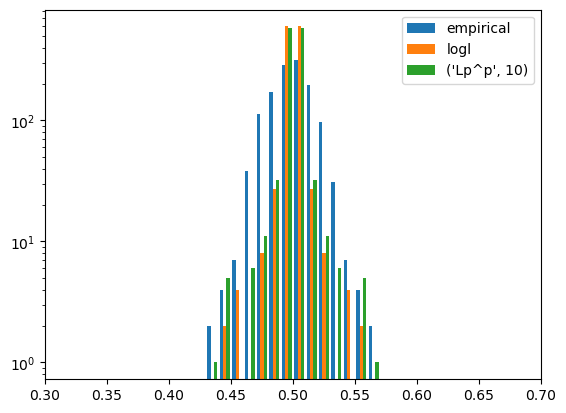

In [7]:
from matplotlib import pyplot as plt
bins = 100
x = np.array([empiri_probs.ravel(), mprobs_logl.ravel(), mprobs_LpP.ravel()]).T
plt.hist(x, bins=bins)
plt.legend(['empirical', 'logl', Lp_est_name ])
plt.yscale('log')
plt.xlim([0.3, 0.7])
plt.show()

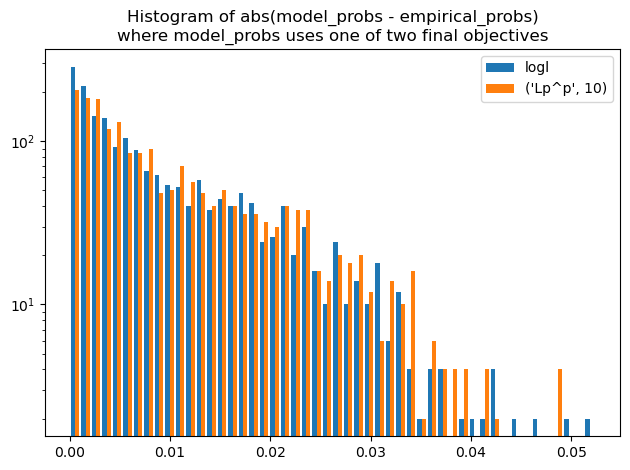

In [8]:
bins = 50
x2 = x[:,1:3].copy()
x2[:,0] = np.abs(x2[:,0] - x[:,0])
x2[:,1] = np.abs(x2[:,1] - x[:,0])
plt.hist(x2, bins=bins)
plt.legend(['logl', Lp_est_name ])
plt.yscale('log')
plt.title('Histogram of abs(model_probs - empirical_probs)\nwhere model_probs uses one of two final objectives')
plt.tight_layout()
plt.show()

In [ ]:
Nsigs = []
ratings = []
from pygsti.report.plothelpers import rated_n_sigma
circuitlist = list(ds.cirIndex.keys())
pvecs = []
objectives = []
for estname, est in results.estimates.items():
    model = est.models['stdgaugeopt']
    Nsig, rating = rated_n_sigma(ds, model, circuitlist, 'logl')
    Nsigs.append(Nsig)
    ratings.append(rating)
    objective = est.final_objective_fn()
    objectives.append(objective)
    # pvecs.append(objective.model.to_vector())
    #
    #   PROBLEM: the to_vector() might be based on full TP for some models and CPTPLND for others, since gauge optimization uses full TP.
    #   I think that objectives will always be with respect to CPTPLND parameterization, at least when fit_mode == 'CPTPLND'.
    #   Note that objective.model is different from model in general, since the latter is obtained by gauge optimizing the former to target.
    #   HOWEVA, there's an issue where objective.model.to_vector() is returning the same value for (very!) different objectives.
    #   I'm not sure what that's about!
    # 
    #   This persists even when I call est.models['final iteration estimate'] instead of relying on objective.model.
    #
    pvecs.append(est.models['final iteration estimate'].to_vector())

print(list(results.estimates.keys()))
print(Nsigs)
print(ratings)

objvals = np.zeros((len(pvecs),len(objectives)-1))
for i,pvec in enumerate(pvecs):
    for j,objective in enumerate(objectives[:-1]):
        val = objective.fn(pvec, stateless=True)
        if val < 1e-8:
            val = val ** 0.1
        objvals[i,j] = val

np.set_printoptions(linewidth=200)
print(objvals)

['logl', 'normalized tvd', 'tvd', "('Lp^p', 10)", 'datagen']
[0.32639205508473434, 3.7837270451549756, 1.1055924120918392, 8.277176250617178, 0.878729720001016]
[5, 4, 5, 4, 5]
[[4.67504133e+02 2.61786237e-01 8.78667563e+00 5.83053781e-02]
 [5.41695997e+02 2.48277943e-01 9.28564031e+00 6.73683489e-02]
 [4.84225199e+02 2.53637734e-01 8.65725433e+00 5.84214073e-02]
 [6.38122108e+02 2.85037849e-01 9.57856631e+00 5.60566961e-02]
 [1.83349018e+06 1.33844594e+01 4.67173129e+02 1.26554588e+02]]


In [ ]:

print()
for est in results.estimates.values():
    print(id(est.final_objective_fn()))
    
print()
for est in results.estimates.values():
    print(id(est.final_objective_fn().model))

print()
for est in results.estimates.values():
    print(est.misfit_sigma())


13495330512
13494092560
13490937360
13512444880
13536979536

6109039248
6109039248
6109039248
6109039248
13517386256

8.277176250618385
-21.482563694498033
-21.482563694498033
-21.482563694498033
8.249399003910483
